### Auteurs:
-Adjoua HOUNDONOUGBO

-Morel MBEDI

**********************************************
### le but est de prévoir la consommation d'électricité régionale(12) et nationale au 31/12/2022 avec de données de résuluiton de 30 mn

données de consommation d'électricité  et météo France du 01/01/2021 AU 31/12/2022
-model prophet pour chaque région + nationale.

-réconcilier les prévisions précalculées avec le model prophet puis utilisons la librairie "scikit-hts" pour effectuer un rapprochement optimal OLS sur les prévisions.

-commentaire des résulats:

l'utilisation de la méthode de réconciliation a permis d'améliorer les prévisions de chaque série car leur RMSE(erreur moyenne quadratique) est inférieure avant la réconciliation

docs utils:

[libraie sklearn.hts](https://scikit-hts.readthedocs.io/en/latest/usage.html#)

[exemple code compétitionkaggle](https://github.com/carlomazzaferro/scikit-hts-examples/blob/master/notebooks/M5.ipynb)

[exemple code compétition kaggle suto-arima](https://github.com/carlomazzaferro/scikit-hts-examples/blob/master/notebooks/visnights.ipynb)

[doc auto-arima](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.AutoARIMA.html)

[code gestion variables exogènes](https://github.com/carlomazzaferro/scikit-hts/issues/55)


In [2]:
### installation de la librairie sklearn-hts
!pip install scikit-hts[all]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 KB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.3/91.3 KB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 KB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.7/925.7 KB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 675.2/675.2 KB 58.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 108.5 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [64]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import hts
from hts import HTSRegressor
import hts.functions
import collections
from hts.utilities.load_data import load_hierarchical_sine_data
import calendar
import holidays
import datetime

Rapprochez vos prévisions. Ici, nous utilisons la réconciliation optimale OLS. Ensuite, placez les prévisions réconciliées dans le même format DataFrame large.

Vous remarquerez que les prévisions sont les. Parce que nous avons utilisé une moyenne pour prévoir, les prévisions étaient déjà cohérentes. Par conséquent, ils restent les mêmes/cohérents après la réconciliation. Démontrer que la réconciliation fonctionne.

In [ ]:
#@title
from datetime import datetime
import hts
from hts.utilities.load_data import load_hierarchical_sine_data
import statsmodels
import collections
import pandas as pd

s, e = datetime(2019, 1, 15), datetime(2019, 10, 15)
hsd = load_hierarchical_sine_data(start=s, end=e, n=10000)
hier = {'total': ['a', 'b', 'c'],
            'a': ['a_x', 'a_y'],
            'b': ['b_x', 'b_y'],
            'c': ['c_x', 'c_y'],
            'a_x': ['a_x_1', 'a_x_2'],
            'a_y': ['a_y_1', 'a_y_2'],
            'b_x': ['b_x_1', 'b_x_2'],
            'b_y': ['b_y_1', 'b_y_2'],
            'c_x': ['c_x_1', 'c_x_2'],
            'c_y': ['c_y_1', 'c_y_2']
        }

tree = hts.hierarchy.HierarchyTree.from_nodes(hier, hsd)
sum_mat, sum_mat_labels = hts.functions.to_sum_mat(tree)

forecasts = pd.DataFrame(columns=hsd.columns, index=['fake'])

    # Make forecasts made outside of package. Could be any modeling technique.
for col in hsd.columns:
        model = statsmodels.tsa.holtwinters.SimpleExpSmoothing(hsd[col].values).fit()
        fcst = list(model.forecast(1))
        forecasts[col] = fcst

pred_dict = collections.OrderedDict()

# Add predictions to dictionary is same order as summing matrix
for label in sum_mat_labels:
        pred_dict[label] = pd.DataFrame(data=forecasts[label].values, columns=['yhat'])

revised = hts.functions.optimal_combination(pred_dict, sum_mat, method='OLS', mse={})

# Put reconciled forecasts in nice DataFrame form
revised_forecasts = pd.DataFrame(data=revised[0:,0:],
                                    index=forecasts.index,columns=sum_mat_labels)

In [4]:
# chargemnt librairie
import pandas as pd
import numpy as np
import os
import calendar
from datetime import datetime
import holidays
import datetime

###chargement de données

In [6]:
directory="/content/drive/MyDrive/MALIA/FORCASTING/projet_forecasting/data_RTE_METEO"
os.chdir(directory)

In [7]:
import time
# temps de chargment
start_time = time.perf_counter()

df=pd.read_csv("df_ajout_var_calendar.csv",delimiter=",")#,nrows=20_000 df_meteo_clean.csv
df['DateHeure'] = pd.to_datetime(df['DateHeure'],utc=True)
end_time = time.perf_counter()
print(end_time-start_time," secondes")

#taille et nombre de colonnes
df.shape

1.3469962850001593  secondes


(455520, 12)

In [114]:
#info sur les colonnes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455520 entries, 0 to 455519
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   DateHeure       455520 non-null  datetime64[ns, UTC]
 1   region          455520 non-null  object             
 2   conso           455520 non-null  int64              
 3   temp            455520 non-null  float64            
 4   heure           455520 non-null  int64              
 5   date            455520 non-null  object             
 6   period_journey  455520 non-null  int64              
 7   isHolyday       455520 non-null  bool               
 8   weekday         455520 non-null  int64              
 9   Weekend         455520 non-null  bool               
 10  Mois            455520 non-null  int64              
 11  year            455520 non-null  int64              
dtypes: bool(2), datetime64[ns, UTC](1), float64(1), int64(6), object(2)
memo

In [9]:
#regardons quelques lignes du df
df

,DateHeure,region,conso,temp,heure,date,period_journey,isHolyday,weekday,Weekend,Mois,year
0,2021-01-01 00:00:00+00:00,Auvergne-Rhône-Alpes,8576,276.125000,0,2021-01-01,0,True,4,False,1,2021
1,2021-01-01 00:00:00+00:00,PACA,6395,277.283333,0,2021-01-01,0,True,4,False,1,2021
2,2021-01-01 00:00:00+00:00,Occitanie,5840,278.416667,0,2021-01-01,0,True,4,False,1,2021
3,2021-01-01 00:00:00+00:00,Bretagne,3984,273.983333,0,2021-01-01,0,True,4,False,1,2021
4,2021-01-01 00:00:00+00:00,Bourgogne-Franche-Comté,2671,275.150000,0,2021-01-01,0,True,4,False,1,2021
...,...,...,...,...,...,...,...,...,...,...,...,...
455515,2022-12-31 21:30:00+00:00,France,43971,284.921227,21,2022-12-31,2,False,5,True,12,2022
455516,2022-12-31 22:00:00+00:00,France,43506,283.521204,22,2022-12-31,3,False,5,True,12,2022
455517,2022-12-31 22:30:00+00:00,France,44566,282.121181,22,2022-12-31,3,False,5,True,12,2022
455518,2022-12-31 23:00:00+00:00,France,46232,280.721157,23,2022-12-31,3,False,5,True,12,2022


###transformation sous forme matricielle

##la librairie prophet
[doc prophet](https://facebook.github.io/prophet/docs/quick_start.html#python-api)

[notebook python prophet](https://nbviewer.org/github/nicolasfauchereau/Auckland_Cycling/blob/master/notebooks/Auckland_cycling_and_weather.ipynb)

In [10]:
!pip install utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


###Prévision de chaque série (12 régions +1 natiionale)
### modèle prophet avec des variables exogènes

In [12]:
from prophet import Prophet
import numpy as np
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error

def model_prophet(df_train, df_test):
    #initialisation du modele
    m = Prophet()
    #add des variables exogènes
    m.add_regressor('temp', prior_scale=0.5, mode='multiplicative')
    m.add_regressor('heure', prior_scale=0.5, mode='multiplicative')
    m.add_regressor('period_journey', prior_scale=0.5, mode='multiplicative')
    m.add_regressor('isHolyday', prior_scale=0.5, mode='multiplicative')
    m.add_regressor('weekday', prior_scale=0.5, mode='multiplicative')
    m.add_regressor('Weekend', prior_scale=0.5, mode='multiplicative')
    m.add_regressor('Mois', prior_scale=0.5, mode='multiplicative')
   
    #fit  model
    m.fit(df_train)
    #preparation df variables exogenes
    futures=df_test.drop(columns=["y"])

    #prediction
    forecast_prophet = m.predict(futures)
    #performance
    mse_prophet = mean_squared_error(df_test.y, forecast_prophet.yhat) 
    return m,forecast_prophet,mse_prophet

In [40]:
#coie du df dans data 
data=df.copy()
#liste de régions
regions=data.region.unique().tolist()
#list resulta de chaque modele de prévision
resultats={}
#resultats de chaque region
df_prevision= pd.date_range(start="2022-12-31", end="2023-01-01",freq='30T')
df_prevision=df_prevision[:-1]
df_prevision = pd.DataFrame(df_prevision,columns=["ds"])
result_region=[]
rmse=[]
for region in regions:
  df_region = data.loc[data["region"].isin([region])]
  df_region=df_region.rename(columns={"DateHeure":"ds","conso":"y"})
  df_region['ds'] = df_region['ds'].dt.tz_localize(None)
  #df_region.set_index('ds', inplace = True)
  df_region=df_region.drop(columns=["region","year","date"])
  #separation data
  df_train, df_test = df_region[:(df_region.shape[0]-48)], df_region[-48:]
  m,forecast_prophet,mse_prophet=model_prophet(df_train, df_test)

  #prevision de chaque region
  df_yhat=forecast_prophet[["ds","yhat"]]
  df_yhat=df_yhat.rename(columns={"yhat":region})
  df_prevision=pd.merge(df_prevision,df_yhat,on="ds")   
  result_region.append(m)
  #RMSE de chaque prevision
  lst_temp=[]
  lst_temp.append(region)
  lst_temp.append(mse_prophet)
  rmse.append(lst_temp)
  #result_region.append(df_yhat)
  #result_region.append(mse_prophet)
  #enregistrement des resultat de chaque region 
  resultats[region]=result_region

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=Tru

In [41]:
rmse

[['Auvergne-Rhône-Alpes', 591481.3804737105],
 ['PACA', 69792.17641872272],
 ['Occitanie', 45385.414123735325],
 ['Bretagne', 84909.36942040865],
 ['Bourgogne-Franche-Comté', 240516.16802158862],
 ['Nouvelle-Aquitaine', 78577.80072093986],
 ['Normandie', 58249.94401501223],
 ['Pays-de-la-Loire', 161496.5878101249],
 ['Ile-de-France', 1191647.341674301],
 ['Hauts-de-France', 135185.93700929312],
 ['Grand-Est', 1636680.2734221832],
 ['Centre-Val de Loire', 113377.51239495944],
 ['France', 38354674.80017722]]

In [42]:
#Erreur moyenne quadratique de chaque séreie (RMSE)
df_rmse=pd.DataFrame(rmse,columns=["region","RMSE"])
df_rmse

,region,RMSE
0,Auvergne-Rhône-Alpes,5.914814e+05
1,PACA,6.979218e+04
2,Occitanie,4.538541e+04
3,Bretagne,8.490937e+04
4,Bourgogne-Franche-Comté,2.405162e+05
5,Nouvelle-Aquitaine,7.857780e+04
6,Normandie,5.824994e+04
7,Pays-de-la-Loire,1.614966e+05
8,Ile-de-France,1.191647e+06
9,Hauts-de-France,1.351859e+05


In [43]:
#renommons la colonne 'France' par 'total' pour être en conforme avec les récommandations
# de la librairie "sklearn-hts" pour faire  la reconciliation 
df_prevision=df_prevision.rename(columns={"France":"total"})
df_prevision

,ds,Auvergne-Rhône-Alpes,PACA,Occitanie,Bretagne,Bourgogne-Franche-Comté,Nouvelle-Aquitaine,Normandie,Pays-de-la-Loire,Ile-de-France,Hauts-de-France,Grand-Est,Centre-Val de Loire,total
0,2022-12-31 00:00:00,6830.919922,4249.436999,4034.951444,2568.128640,2013.883693,4452.130971,3079.275387,3148.514214,7639.436771,5559.426352,4678.761210,2116.680233,49117.439238
1,2022-12-31 00:30:00,6806.645037,4255.984379,3995.821267,2537.551633,2002.980536,4458.790190,3047.922179,3150.204360,7481.859912,5521.103527,4673.325699,2091.961015,48751.174922
2,2022-12-31 01:00:00,6768.578155,4244.779316,3931.027221,2470.349042,1990.975609,4438.621896,2991.203939,3115.871660,7292.523493,5438.995033,4650.104787,2050.926649,48086.805838
3,2022-12-31 01:30:00,6709.278964,4200.520689,3855.641989,2400.427098,1983.660423,4391.979952,2926.886946,3048.994918,7075.277079,5348.048250,4612.654795,2004.948418,47246.181475
4,2022-12-31 02:00:00,6629.969146,4123.682152,3746.139425,2297.350361,1965.106454,4302.094400,2841.404558,2947.652486,6830.717464,5207.267619,4547.980989,1940.640676,46047.114087
5,2022-12-31 02:30:00,6537.797792,4015.901174,3631.681424,2205.172794,1945.465663,4188.026317,2760.482644,2832.078342,6584.959511,5070.008753,4473.283123,1876.785531,44777.082603
6,2022-12-31 03:00:00,6447.978952,3895.168448,3503.133224,2101.739324,1915.220259,4053.106950,2676.798190,2714.058808,6358.052111,4912.137783,4388.974095,1807.125346,43412.110115
7,2022-12-31 03:30:00,6373.409561,3771.652267,3405.114318,2034.954790,1891.722735,3928.970023,2623.669376,2624.120392,6199.008428,4806.393772,4325.307691,1760.851735,42381.289500
8,2022-12-31 04:00:00,6336.534957,3675.130604,3328.366999,1982.213681,1870.212603,3831.190240,2587.869111,2570.099888,6116.213911,4722.115752,4282.858027,1727.526325,41660.959482
9,2022-12-31 04:30:00,6349.856347,3618.761760,3309.561731,1985.777151,1869.832452,3793.300630,2592.772262,2570.416787,6134.895243,4715.900208,4284.889428,1727.993528,41592.096535


In [53]:
#retrait de la colonne "France" dans la liste "regions"
#regions=regions[:-1]

###reconciliation

###préparation de données pour la réconciliation

In [54]:
regions=['Auvergne-Rhône-Alpes', 'PACA', 'Occitanie', 'Bretagne',
       'Bourgogne-Franche-Comté', 'Nouvelle-Aquitaine', 'Normandie',
       'Pays-de-la-Loire', 'Ile-de-France', 'Hauts-de-France', 'Grand-Est',
       'Centre-Val de Loire',"total"]
dfmatrix = df.pivot_table(index="DateHeure", columns="region", values="conso")
dfmatrix=dfmatrix.rename(columns={"France":"total"})
dfmatrix=dfmatrix[regions]
dfmatrix

region,Auvergne-Rhône-Alpes,PACA,Occitanie,Bretagne,Bourgogne-Franche-Comté,Nouvelle-Aquitaine,Normandie,Pays-de-la-Loire,Ile-de-France,Hauts-de-France,Grand-Est,Centre-Val de Loire,total
DateHeure,,,,,,,,,,,,,
2021-01-01 00:00:00+00:00,8576,6395,5840,3984,2671,6512,4326,4230,9914,6340,5321,2900,67010
2021-01-01 00:30:00+00:00,8514,6290,5713,3968,2618,6522,4288,4292,9838,6566,5485,2977,67071
2021-01-01 01:00:00+00:00,8273,6106,5460,3780,2576,6375,4185,4135,9537,6393,5332,2900,65052
2021-01-01 01:30:00+00:00,8253,6102,5421,3705,2604,6581,4193,4158,9201,6403,5355,2942,64918
2021-01-01 02:00:00+00:00,8234,5970,5365,3790,2646,6465,4179,4216,8970,6284,5390,2865,64376
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 21:30:00+00:00,6471,4342,3990,2134,1790,4285,2959,2642,7152,5611,3540,1798,43971
2022-12-31 22:00:00+00:00,6409,4323,3954,2179,1748,4333,2997,2616,7010,5692,3550,1810,43506
2022-12-31 22:30:00+00:00,6561,4358,4081,2221,1704,4460,3076,2807,7063,5666,3555,1792,44566


In [55]:
df_prevision.columns[1:-1].tolist()

['Auvergne-Rhône-Alpes',
 'PACA',
 'Occitanie',
 'Bretagne',
 'Bourgogne-Franche-Comté',
 'Nouvelle-Aquitaine',
 'Normandie',
 'Pays-de-la-Loire',
 'Ile-de-France',
 'Hauts-de-France',
 'Grand-Est',
 'Centre-Val de Loire']

In [57]:
regions

['Auvergne-Rhône-Alpes',
 'PACA',
 'Occitanie',
 'Bretagne',
 'Bourgogne-Franche-Comté',
 'Nouvelle-Aquitaine',
 'Normandie',
 'Pays-de-la-Loire',
 'Ile-de-France',
 'Hauts-de-France',
 'Grand-Est',
 'Centre-Val de Loire']

In [59]:
#regions=df_prevision.columns[1:-1].tolist()
regions=regions[:-1]
hier ={'total': regions}
hier

{'total': ['Auvergne-Rhône-Alpes',
  'PACA',
  'Occitanie',
  'Bretagne',
  'Bourgogne-Franche-Comté',
  'Nouvelle-Aquitaine',
  'Normandie',
  'Pays-de-la-Loire',
  'Ile-de-France',
  'Hauts-de-France',
  'Grand-Est',
  'Centre-Val de Loire']}

In [65]:
regions=df_prevision.columns[1:-1].tolist()
hier ={'total': regions}
tree = hts.hierarchy.HierarchyTree.from_nodes(hier, dfmatrix)
sum_mat, sum_mat_labels = hts.functions.to_sum_mat(tree)

pred_dict = collections.OrderedDict()

#Ajoutons des prédictions au dictionnaire dans le même ordre que la matrice de sommation
for label in sum_mat_labels:
        pred_dict[label] = pd.DataFrame(data=df_prevision[label].values, columns=['yhat'])

revised = hts.functions.optimal_combination(pred_dict, sum_mat, method='OLS', mse={})

# Mettons les prévisions réconciliées sous une belle forme DataFrame
revised_forecasts = pd.DataFrame(data=revised[0:,0:],
                                    index=df_prevision.index,columns=sum_mat_labels)

In [ ]:
revised_forecasts

,total,Auvergne-Rhône-Alpes,PACA,Occitanie,Bretagne,Bourgogne-Franche-Comté,Nouvelle-Aquitaine,Normandie,Pays-de-la-Loire,Ile-de-France,Hauts-de-France,Grand-Est,Centre-Val de Loire
0,49213.908977,6734.450184,4152.967260,3938.481705,2471.658902,1917.413955,4355.661233,2982.805649,3052.044475,7542.967033,5462.956614,4582.291472,2020.210495
1,48849.096061,6708.723897,4158.063240,3897.900127,2439.630494,1905.059397,4360.869051,2950.001039,3052.283220,7383.938772,5423.182388,4575.404559,1994.039876
2,48186.586682,6668.797312,4144.998473,3831.246378,2370.568199,1891.194766,4338.841052,2891.423095,3016.090816,7192.742650,5339.214190,4550.323944,1951.145806
3,47347.115170,6608.345268,4099.586993,3754.708293,2299.493402,1882.726727,4291.046256,2825.953250,2948.061222,6974.343383,5247.114554,4511.721099,1904.014722
4,46149.644213,6527.439020,4021.152026,3643.609298,2194.820234,1862.576328,4199.564274,2738.874431,2845.122360,6728.187337,5104.737493,4445.450863,1838.110549
5,44880.510331,6434.370064,3912.473446,3528.253696,2101.745066,1842.037935,4084.598589,2657.054916,2728.650614,6481.531783,4966.581025,4369.855395,1773.357803
6,43516.831913,6343.257154,3790.446650,3398.411425,1997.017526,1810.498461,3948.385152,2572.076392,2609.337010,6253.330312,4807.415985,4284.252297,1702.403548
7,42486.203776,6268.495285,3666.737991,3300.200042,1930.040514,1786.808459,3824.055747,2518.755100,2519.206116,6094.094152,4701.479496,4220.393415,1655.937459
8,41766.295837,6231.198602,3569.794249,3223.030644,1876.877326,1764.876248,3725.853885,2482.532756,2464.763533,6010.877556,4616.779397,4177.521672,1622.189970
9,41696.855073,6245.097809,3514.003222,3204.803193,1881.018613,1765.073914,3688.542092,2488.013725,2465.658249,6030.136706,4611.141670,4180.130891,1623.234990


In [66]:
#évaluation des modèles avec RMSE
Xtrain, Xtest = dfmatrix[:(dfmatrix.shape[0]-48)], dfmatrix[-48:]
Xtest=Xtest[revised_forecasts.columns.tolist()]

In [67]:
Xtest.shape

(48, 13)

In [68]:
#calculons le RMSE pour chaque série
RMSE_revised=[]
for region in revised_forecasts.columns.tolist():
  observed=Xtest[region]
  forecast=revised_forecasts[region]
  temp=[]
  RMSE=mean_squared_error(observed,forecast) 
  temp.append(region)
  temp.append(RMSE)
  RMSE_revised.append(temp)

In [69]:
#mettons les RMSE  de chque série sous forme d'un df 
df_RMSE_revised=pd.DataFrame(RMSE_revised,columns=["region","RMSE_reconciliation"])

In [70]:
df_RMSE_revised

,region,RMSE_reconciliation
0,total,3.940641e+07
1,Auvergne-Rhône-Alpes,4.732445e+05
2,PACA,1.139537e+05
3,Occitanie,5.410755e+04
4,Bretagne,4.926269e+04
5,Bourgogne-Franche-Comté,1.613032e+05
6,Nouvelle-Aquitaine,5.515540e+04
7,Normandie,3.454584e+04
8,Pays-de-la-Loire,1.052295e+05
9,Ile-de-France,1.018516e+06


In [71]:
df_rmse['region']= df_rmse['region'].replace(['France'],['total'])


In [72]:
df_rmse_sort=df_rmse.sort_values(by="region")
df_RMSE_revised_sort=df_RMSE_revised.sort_values(by="region")

In [73]:
df_RMSE_revised_sort

,region,RMSE_reconciliation
1,Auvergne-Rhône-Alpes,4.732445e+05
5,Bourgogne-Franche-Comté,1.613032e+05
4,Bretagne,4.926269e+04
12,Centre-Val de Loire,6.795972e+04
11,Grand-Est,1.412855e+06
10,Hauts-de-France,2.000410e+05
9,Ile-de-France,1.018516e+06
7,Normandie,3.454584e+04
6,Nouvelle-Aquitaine,5.515540e+04
3,Occitanie,5.410755e+04


In [74]:
#compraisions des résultats  modèle simple (prophet) vs reconciliation
df_comp_rmse=pd.merge(df_rmse_sort, df_RMSE_revised_sort,on="region")
df_comp_rmse

,region,RMSE,RMSE_reconciliation
0,Auvergne-Rhône-Alpes,5.914814e+05,4.732445e+05
1,Bourgogne-Franche-Comté,2.405162e+05,1.613032e+05
2,Bretagne,8.490937e+04,4.926269e+04
3,Centre-Val de Loire,1.133775e+05,6.795972e+04
4,Grand-Est,1.636680e+06,1.412855e+06
5,Hauts-de-France,1.351859e+05,2.000410e+05
6,Ile-de-France,1.191647e+06,1.018516e+06
7,Normandie,5.824994e+04,3.454584e+04
8,Nouvelle-Aquitaine,7.857780e+04,5.515540e+04
9,Occitanie,4.538541e+04,5.410755e+04


In [77]:
#sauvagarde des RMSE  
df_comp_rmse.to_csv('df_comp_rmse.xlsx')

###prévision de la consommation nationale au 31/12/2022  avec prophet et visualisation des réusltats

In [109]:
#modele de prévision en frnace et graphique de visualisation
df_france=df.loc[df["region"].isin(["France"])]
df_france=df_france.rename(columns={"DateHeure":"ds","conso":"y"})
df_france['ds'] = df_france['ds'].dt.tz_localize(None)
  #df_region.set_index('ds', inplace = True)
df_france=df_france.drop(columns=["region","year","date"])
  #separation data
df_train, df_test = df_france[:(df_france.shape[0]-48)], df_france[-48:]
model_france,forecast_france,mse_france=model_prophet(df_train, df_test)
 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [110]:
# Python
from prophet.plot import plot_plotly, plot_components_plotly
plot_plotly(model_france, forecast_france)


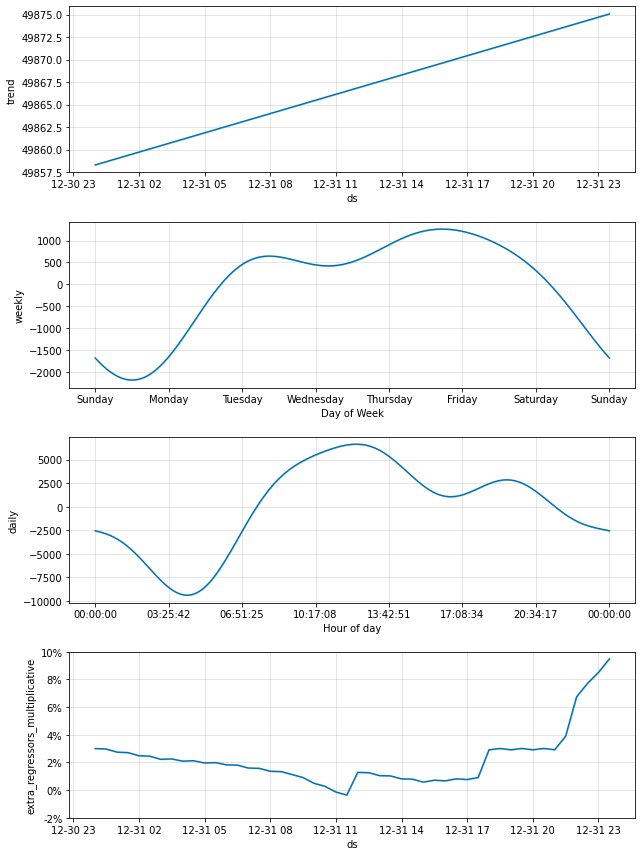

In [111]:
from prophet import Prophet
import utils
fig2 = model_france.plot_components(forecast_france)


In [112]:
# graphique avec plotly ,graphique interactif
plot_components_plotly(model_france, forecast_france)